In [1]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

DATASET_DIR = './VWCADataset/'

### libraries

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import metrics

In [3]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

### Dataset preprocessing

In [4]:
# original dataset
df_CVE = pd.read_csv(DATASET_DIR+'cve_data.csv',low_memory=False)
df_CWE = pd.read_csv(DATASET_DIR+'cwe_data.csv',low_memory=False)

In [5]:
# copy these to apply modification
df_CWE_updated = df_CWE.copy()
df_CWE_updated['index'] = range(len(df_CWE_updated))

In [6]:
# CWE id to serial no dictionary
id_to_index_dict = dict(zip(df_CWE_updated['ID'], df_CWE_updated['index']))
index_to_id_dict = dict(zip(df_CWE_updated['index'], df_CWE_updated['ID']))

In [7]:
def process_cwe_ids(cell_value):
    processed_array = np.zeros(len(id_to_index_dict))
    
    if pd.isnull(cell_value):
        return processed_array
    
    cwe_numbers = [int(num) for num in cell_value.split(',') if num.isdigit()]
    
    for num in cwe_numbers:
        if num in id_to_index_dict:
            processed_array[id_to_index_dict[num]] = 1    
    return processed_array

df_CVE_updated = df_CVE.copy()
df_CVE_updated['Processed_CWE_IDs'] = df_CVE['Related_CWE_IDs'].apply(process_cwe_ids)

In [8]:
df_CVE_updated['Labeled'] = df_CVE_updated['Processed_CWE_IDs'].apply(lambda x: any(val == 1 for val in x))

In [79]:
df_CVE_updated.head()

,ID,Related_CWE_IDs,Description,BaseScore,Severity,Exploitability_Score,Impact_Score,Processed_CWE_IDs,Labeled
0,CVE-1999-0001,20,ip_input.c in BSD-derived TCP/IP implementatio...,5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
1,CVE-1999-0002,119,Buffer overflow in NFS mountd gives root acces...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
2,CVE-1999-0003,Other,Execute commands as root via buffer overflow i...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
3,CVE-1999-0004,Other,"MIME buffer overflow in email clients, e.g. So...",5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
4,CVE-1999-0005,Other,Arbitrary command execution via IMAP buffer ov...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False


In [80]:
df_CVE_labeled = df_CVE_updated[df_CVE_updated['Labeled']]
df_CVE_labeled.head()

,ID,Related_CWE_IDs,Description,BaseScore,Severity,Exploitability_Score,Impact_Score,Processed_CWE_IDs,Labeled
0,CVE-1999-0001,20,ip_input.c in BSD-derived TCP/IP implementatio...,5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
1,CVE-1999-0002,119,Buffer overflow in NFS mountd gives root acces...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
6,CVE-1999-0007,327,Information from SSL-encrypted sessions via PK...,5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
26,CVE-1999-0027,119,root privileges via buffer overflow in eject c...,7.2,HIGH,3.9,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
45,CVE-1999-0046,120,Buffer overflow of rlogin program using TERM e...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True


### Dataset 

In [11]:
class CVEDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Description
        self.targets = self.data.Processed_CWE_IDs
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            truncation = True,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True,
            padding = 'max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [81]:
train_size = 0.8
all_df_CVE = df_CVE_updated.copy()
all_df_CVE = all_df_CVE.reset_index(drop=True)
train_data=df_CVE_labeled.sample(frac=train_size,random_state=200)
test_data=df_CVE_labeled.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(all_df_CVE.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

FULL Dataset: (242504, 9)
TRAIN Dataset: (124186, 9)
TEST Dataset: (31047, 9)


In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [14]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 1024
VALID_BATCH_SIZE = 2048
EPOCHS = 1
LEARNING_RATE = 1e-03

In [82]:
training_set = CVEDataset(train_data, tokenizer, MAX_LEN)
testing_set = CVEDataset(test_data, tokenizer, MAX_LEN)
all_set = CVEDataset(all_df_CVE, tokenizer, MAX_LEN)

In [83]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 4
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

all_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }


training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
all_loader = DataLoader(all_set, **all_params)

In [77]:
# for i,j in enumerate(training_loader):
#     print(i,j)
#     if i>5:
#         break

### LLM Training

- https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_multiclass_classification.ipynb#scrollTo=rcUi1Gd5KCzC

- https://huggingface.co/distilbert/distilbert-base-uncased

- https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=MZ_wI0YwDVJZ

In [18]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class V2WBERTClass(torch.nn.Module):
    def __init__(self, num_class=2):
        super(V2WBERTClass, self).__init__()
        self.base_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        layername = 'layer.5'
        
        for name, param in self.base_model.named_parameters():                       
            #print(name)            
            if layername in name:
                print("Froze upto: ", name)
                break
            else:
                param.requires_grad = False
        
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, num_class)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = V2WBERTClass(num_class=len(id_to_index_dict))
model.to(device)

Froze upto:  transformer.layer.5.attention.q_lin.weight


V2WBERTClass(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [19]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [20]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [32]:
def train(epoch):
    model.train()
    for i,data in enumerate(pbar :=tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
#         if i%10==0:
#             print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        pbar.set_postfix({'Epoch':epoch, 'Loss': loss.item()})
        
        loss.backward()
        optimizer.step()

In [33]:
EPOCHS = 25

In [34]:
for epoch in range(EPOCHS):
    train(epoch)

 27%|██▋       | 33/122 [00:50<02:13,  1.50s/it, Epoch=15, Loss=0.0012] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 122/122 [03:03<00:00,  1.50s/it, Epoch=24, Loss=0.000867]


In [35]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(pbar :=tqdm(testing_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [56]:
outputs, targets = validation(testing_loader)
# outputs, targets = validation(training_loader)
# final_outputs = np.array(outputs) >=0.5

100%|██████████| 16/16 [00:56<00:00,  3.53s/it]


In [203]:
def th_predictions(outs, ths=0.50):
    outs = np.array(outs)
    greater_than_threshold = outs >= ths
    max_values = np.max(outs, axis=1, keepdims=True)
    less_than_threshold = np.isclose(outs,max_values, rtol=0.0001)
    result = np.logical_or(greater_than_threshold, less_than_threshold)
    
    return result
    
final_outputs = th_predictions(outputs,0.50)

In [204]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [205]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.7789802557412955
Hamming Loss = 0.0004607291373902984


### Save and Load model

In [206]:
print("Saving model of....")
print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

torch.save(model.state_dict(), RESULTS_DIR+'2VW24DistilBERTClass')

Saving model of....
Hamming Score = 0.7789802557412955
Hamming Loss = 0.0004607291373902984


In [45]:
# checkpoint = torch.load(MODEL_NAME, map_location=lambda storage, loc: storage)
# model.load_state_dict(checkpoint)

### CVEs to CWEs mapping

In [209]:
def prediction(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(pbar :=tqdm(testing_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                        
#             break
            
    f_targets = np.array(fin_targets) >= 0.25
    f_outputs = np.array(fin_outputs) >= 0.25
    
    true_indices = [np.where(row)[0] for row in f_targets]
    pred_indices = [np.where(row)[0] for row in f_outputs]
    
    print(true_indices[0])
    print(pred_indices[0])
                
    return true_indices, pred_indices

#true_indices, pred_indices = prediction(testing_loader)
true_indices, pred_indices = prediction(all_loader)

100%|██████████| 119/119 [07:11<00:00,  3.63s/it]


[332]
[332]


In [210]:
## Save mapping
def save_mapping():
    t_cwes = []
    p_cwes = []

    for row in true_indices:
        t_cwes.append([index_to_id_dict[c] for c in row])

    for row in pred_indices:
        p_cwes.append([index_to_id_dict[c] for c in row])

    print(t_cwes[0], p_cwes[0])

    all_df_CVE['TrueCWEs']=t_cwes
    all_df_CVE['PredCWEs']=p_cwes

save_mapping()

[20] [20]


In [211]:
all_df_CVE.head()

,ID,Related_CWE_IDs,Description,BaseScore,Severity,Exploitability_Score,Impact_Score,Processed_CWE_IDs,Labeled,TrueCWEs,PredCWEs
0,CVE-1999-0001,20,ip_input.c in BSD-derived TCP/IP implementatio...,5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,[20],[20]
1,CVE-1999-0002,119,Buffer overflow in NFS mountd gives root acces...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,[119],"[119, 120]"
2,CVE-1999-0003,Other,Execute commands as root via buffer overflow i...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,[],[120]
3,CVE-1999-0004,Other,"MIME buffer overflow in email clients, e.g. So...",5.0,MEDIUM,10.0,2.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,[],[119]
4,CVE-1999-0005,Other,Arbitrary command execution via IMAP buffer ov...,10.0,HIGH,10.0,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,[],[120]


In [212]:
all_df_CVE.to_csv(RESULTS_DIR+'2VW24DistilBERTClass.csv',index=False)

### Transformation to Vector

In [117]:
def save_transform(filename,infos):    
    f=open(filename, 'a+')
    np.savetxt(f, infos)    
    f.close()

In [166]:
def TransformDataset(dataloader, filename):
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(pbar :=tqdm(dataloader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            output_1 = model.base_model(input_ids=ids, attention_mask=mask)
            hidden_state = output_1[0]
            pooler = hidden_state[:, 0]
            
            save_transform(filename, pooler.detach().cpu().numpy())
#             print(pooler.shape)
#             break
            

# filename = RESULTS_DIR+'2VW24DistilBERTClassVec.txt'
# f=open(filename, 'w')
# f.close()
# TransformDataset(all_loader, filename)
# TransformDataset(training_loader, filename)

100%|██████████| 119/119 [08:20<00:00,  4.20s/it]


In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# plt.style.use('seaborn-whitegrid')

(200, 768)
(200,)
(200, 963)


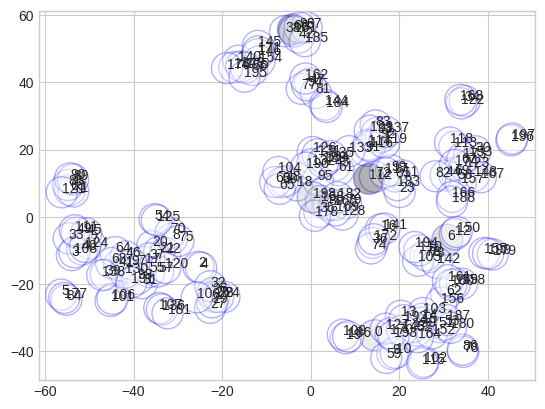

In [213]:
def visualize_data(TAKE=20):
    rep=np.loadtxt(filename, dtype=float, max_rows=TAKE)
    print(rep.shape)
    
    transformed = TSNE(n_components=2, perplexity=3, metric='euclidean').fit_transform(rep)
    color=all_df_CVE['Processed_CWE_IDs'].iloc[:TAKE].to_numpy()
    
    print(color.shape)
    color = np.stack(color)
    print(color.shape)

    if(len(color[0])>1):
        color=np.argmax(color,axis=1)        
        
#     print(color)

    plt.scatter(transformed[:,0],transformed[:,1], c=color, edgecolor='b', s=500, alpha=0.3 )

    for i in range(len(transformed)):
        plt.annotate(str(i),(transformed[i,0],transformed[i,1]))

    plt.show()    

visualize_data(TAKE=200)

## Scratch

In [40]:
# model = DistilBertModel.from_pretrained("distilbert-base-uncased")
# #text = "Replace me by any text you'd like."
# text = df_CVE['Description'][0]
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)
# output.last_hidden_state.shape
# output.last_hidden_state[:,0].shape

In [41]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# encoded_input

In [42]:
# inputs = tokenizer.encode_plus(
#             text,
#             truncation = True,
#             add_special_tokens=True,
#             max_length=100,
#             pad_to_max_length=True,
#             return_token_type_ids=True
#         )
# inputs